# Logistic Regression and Newton's Method

This is a worked solution in Julia to [Exercise 4](http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex4/ex4.html) from Andrew Ng's [Machine Learning](http://openclassroom.stanford.edu/MainFolder/CoursePage.php?course=MachineLearning) course on Stanford's [OpenClassroom](http://openclassroom.stanford.edu/MainFolder/HomePage.php).
$
\newcommand{\cond}{{\mkern+2mu} \vert {\mkern+2mu}}
\newcommand{\SetDiff}{\mathrel{\backslash}}
\DeclareMathOperator{\BetaFunc}{Β}
\DeclareMathOperator{\GammaFunc}{Γ}
\DeclareMathOperator{\prob}{p}
\DeclareMathOperator{\cost}{J}
\DeclareMathOperator{\score}{V}
\DeclareMathOperator{\gradient}{\nabla}
\DeclareMathOperator{\Hessian}{H}
\DeclareMathOperator{\dcategorical}{Categorical}
\DeclareMathOperator{\dcategorical}{Categorical}
\DeclareMathOperator{\ddirichlet}{Dirichlet}
\DeclareMathOperator{\E}{e}
$

In [1]:
using Distributions
using Plots

gadfly();

## Plotting

Set up the [Plots.jl](https://github.com/tbreloff/Plots.jl) package along with a simple scatter plot and probability contour overlay.

In [2]:
function base_plot(X, Y)
    scatter(
        x = X[:, 2], xlabel = "Exam 1 score", xlimits = (10, 70),
        y = X[:, 3], ylabel = "Exam 2 score", ylims = (40, 90),
        group = map((y) -> ["Not admitted", "Admitted"][y+1], Y),
        markercolor = [colorant"Red" colorant"LightSkyBlue"],
        markersize = 4,
        size = (750, 500) )
end

function contour_plot(X, Y, θ)
    plt = base_plot(X, Y)
    plot!(
        plt,
        linspace(10, 70),
        linspace(40, 100),
        (x, y) -> h([1, x, y], θ) )
end;

## Data

The data for this exercise is downloaded and unpacked from [ex4Data.zip](http://openclassroom.stanford.edu/MainFolder/courses/MachineLearning/exercises/ex4materials/ex4Data.zip). We add an intercept column to the matrix of predictors.

In [3]:
Y = convert(AbstractVector{Int}, vec(readdlm("ex4y.dat")))
N = length(Y)
X = [ones(N) readdlm("ex4x.dat")];

## Plot the data

First thing to do is to look at the data.

[Plots.jl] Initializing backend: gadfly

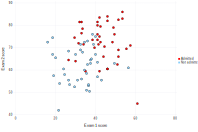

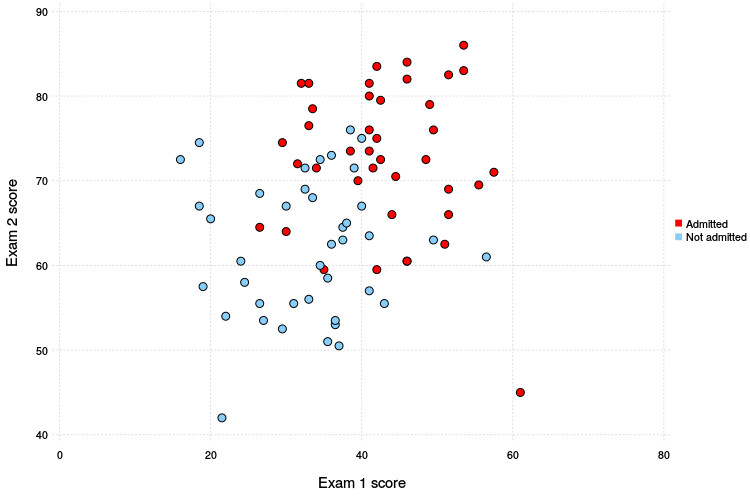

In [4]:
base_plot(X, Y)

## Implementation

The sigmoid function, $g(α) = \dfrac{1}{1 + \E^{-α}}$.

In [5]:
function σ(α)
    1 ./ (1 .+ exp(-α))
end;

The hypothesis function, $h_θ(x) = g(θ^{\text{T}}x) = \prob(y = 1 \cond x; θ)$.

In [6]:
function h(xₙ::AbstractVector, θ::AbstractVector)
    σ(dot(xₙ, θ))
end

function h(X::AbstractMatrix, θ::AbstractVector)
    σ(X * θ)
end;

The cost function, $\cost(θ)$, is defined as

$$
\cost(θ) = \frac{1}{N} \sum_{n=1}^N \big[ -y_n \log(h_θ(x_n)) - (1 - y_n) \log(1 - h_θ(x_n)) \big].
$$

In [7]:
function cost(X, Y, θ)
    N = length(Y)
    hₓ = h(X, θ)

    sum(-Y .* log(hₓ) - (1 .- Y) .* log(1 - hₓ)) / N
end;

The gradient, $\gradient_θ\cost$, is
$$
\gradient_θ\cost = \frac{1}{N} \sum_{n=1}^N (h_θ(x_n) - y_n) x_n.
$$

In [8]:
function gradient(X, Y, θ)
    N = length(Y)
    hₓ = h(X, θ)

    vec(sum((hₓ .- Y) .* X, 1)) / N
end;

The Hessian, $\Hessian$, is
$$
\Hessian = \frac{1}{N} \sum_{n=1}^N \big[ h_θ(x_n) (1 - h_θ(x_n)) x_n x_n^{\text{T}} \big].
$$

In [9]:
function Hessian(X::AbstractMatrix, Y::AbstractVector, θ::AbstractVector)
    N = length(Y)
    P = length(θ)
    hₓ = h(X, θ)

    σ² = hₓ .* (1 - hₓ)

    H = zeros(Float64, (P, P))

    for i in 1:N
        H .+= σ²[i] .* X[i, :] * X[i, :]'
    end

    return H ./ N
end;

The update rule for Newton's method is $θ′ = θ - \Hessian^{-1} \gradient_θ \cost$.

In [10]:
function Newtons(X, Y, θ)
    MAX_ITER = 1000
    TOLERANCE = 1e-9

    J = Array{Float64}(MAX_ITER)
    J[1] = cost(X, Y, θ)

    for i in 2:MAX_ITER
        ∇J = gradient(X, Y, θ)
        H = Hessian(X, Y, θ)

        θ -= H \ ∇J

        J[i] = cost(X, Y, θ)

        if norm(J[i] - J[i-1]) < TOLERANCE
            return (θ, J[1:i])
        end
    end

    error("Failed to converge after $MAX_ITER iterations")
end;

Now we can use Newton's method to solve the classification problem. We use not quite zeros as the initial parameter value to break symmetry.

In [11]:
initialθ = rand(Normal(0, 0.01), (3,));

In [12]:
(θ, J) = Newtons(X, Y, initialθ)

println("Number of iterations to convergence = $(length(J))");
println("");
println("θ₀ = $(θ[1])");
println("θ₁ = $(θ[2])");
println("θ₂ = $(θ[3])");

Number of iterations to convergence = 7


A plot of the value of the cost function at each iteration demonstrates the speed of convergence.

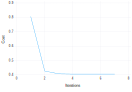

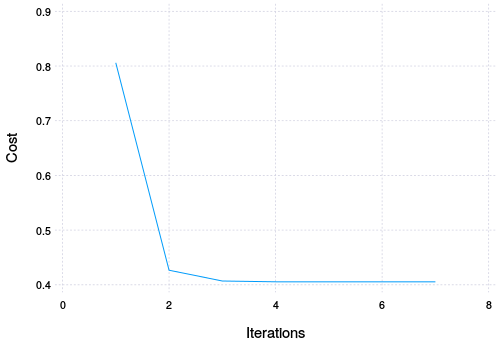


θ₀ = -16.37874341028874
θ₁ = 0.14834077372488547
θ₂ = 0.15890845179345967


In [13]:
plot(
    J,
    xlabel = "Iterations", ylabel = "Cost", legend = false,
    size = (500, 350) )

## Decision boundary

Given a solution to the classification problem, we can plot the decision boundary over the data. The plot here shows not the decision boundary itself but the contours of $\prob(y = 1 \cond x; θ)$, the class probabilities. The decision boundary is at $\prob(y = 1 \cond x; θ) = 0.5$, which corresponds to $θ^{\text{T}}x = 0$.

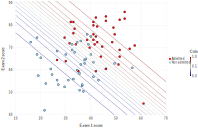

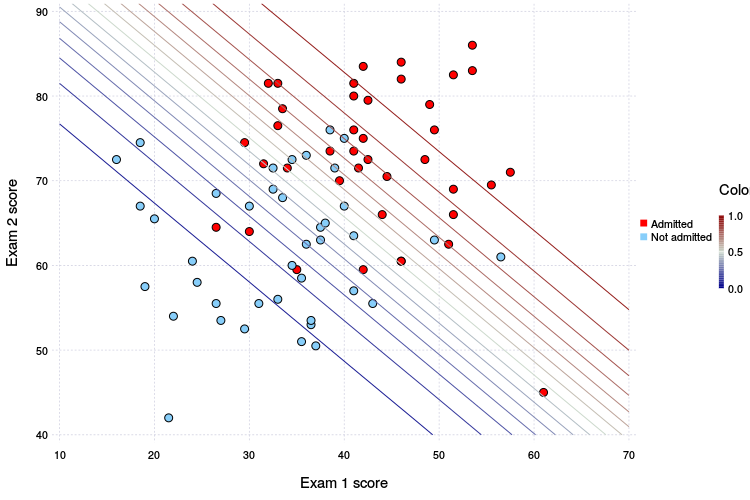

In [14]:
contour_plot(X, Y, θ)